<a href="https://colab.research.google.com/github/ameja101/Smart_City-AI/blob/main/Dashborad_EnuguSmartAICity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install ultralytics opencv-python
!pip install pandas numpy matplotlib
!pip install prophet
!pip install folium osmnx geopandas shapely
!pip install tqdm




from ultralytics import YOLO
import cv2
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import os

# Load YOLOv8 Model

model = YOLO("yolov8s.pt")

# Upload or Load Sample Traffic Video

from google.colab import files
uploaded = files.upload()

video_path = list(uploaded.keys())[0]
print("Using video:", r"C:\Smart City_ AI_MVP\ENUGU NIGERIA 2022 Drive Around Enugu State(Uwani, Agbani road, Enugu-PH expressway & Ituku ozalla).mp4") # Fixed syntax warning by using raw string literal

# Run Incident Detection

cap = cv2.VideoCapture(video_path)

incident_log = []
frame_count = 0
fps = cap.get(cv2.CAP_PROP_FPS)

vehicle_track = {}  # track vehicle positions over time

print("Running detection...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    timestamp = frame_count / fps

    results = model(frame, verbose=False)

    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy()
        cls = r.boxes.cls.cpu().numpy()
        conf = r.boxes.conf.cpu().numpy()

        for box, c, p in zip(boxes, cls, conf):
            if p < 0.50:
                continue

            x1, y1, x2, y2 = box
            center_x = int((x1 + x2) / 2)

            track_id = str(center_x)

            if track_id not in vehicle_track:
                vehicle_track[track_id] = {"last_x": center_x, "still_time": 0}

            prev_x = vehicle_track[track_id]["last_x"]
            vehicle_track[track_id]["last_x"] = center_x

            if abs(center_x - prev_x) < 3:
                vehicle_track[track_id]["still_time"] += 1/fps

            # detect stationary vehicle
            if vehicle_track[track_id]["still_time"] > 20:
                incident_log.append([
                    timestamp, "Stopped Vehicle", int(x1), int(y1), int(x2), int(y2)
                ])

cap.release()

incident_df = pd.DataFrame(incident_log, columns=[
    "timestamp", "incident_type", "x1", "y1", "x2", "y2"
])

incident_df.to_csv("incidents_enugu.csv", index=False)

incident_df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Saving ENUGU NIGERIA 2022 Drive Around Enugu State(Uwani, Agbani road, Enugu-PH expressway & Ituku ozalla).mp4 to ENUGU NIGERIA 2022 Drive Around Enugu State(Uwani, Agbani road, Enugu-PH expressway & Ituku ozalla).mp4
Using video: C:\Smart City_ AI_MVP\ENUGU NIGERIA 2022 Drive Around Enugu State(Uwani, Agbani road, Enugu-PH expressway & Ituku ozalla).mp4
Running detection...


,timestamp,incident_type,x1,y1,x2,y2


CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.37.0
Download successful, file: /tmp/tmpllfpltbp
Extracting distribution
Unpacked download as cmdstan-2.37.0
Building version cmdstan-2.37.0, may take several minutes, depending on your system.
Overwrite requested, remove existing build of version cmdstan-2.37.0
Rebuilding version cmdstan-2.37.0
Installed cmdstan-2.37.0
Test model compilation
Setting cmdstanpy path to: /root/.cmdstan/cmdstan-2.37.0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


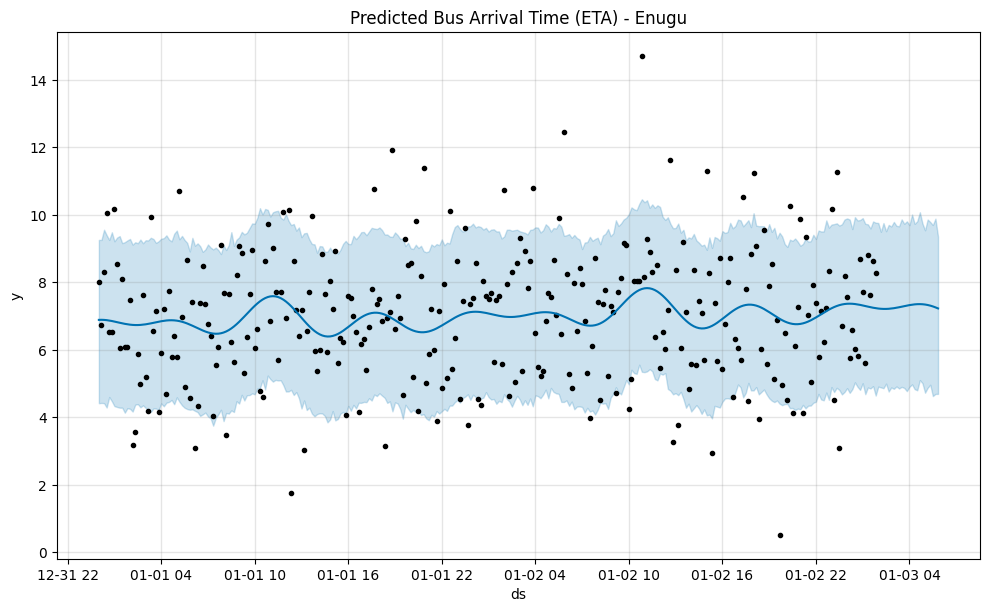

In [ ]:
!pip install osmnx # Ensure osmnx is installed

#  Import Libraries
import osmnx as ox
import folium
import pandas as pd
import numpy as np
import cmdstanpy
import os
import shutil # Import shutil for removing directories

# --- Workaround: Patch Prophet's internal CMDSTANPYBackend __init__ method ---
# This prevents Prophet from overriding cmdstanpy's path with its potentially broken bundled version.
# This must be done BEFORE importing Prophet to ensure the patch takes effect on the class definition.

# Dynamically get the Prophet module's path to correctly target the class
import sys
import types

# Create a mock cmdstanpy module if it's not already loaded, to prevent errors during patching
# This is a precaution if Prophet tries to import cmdstanpy very early.
if 'prophet' not in sys.modules:
    # Define a custom meta path finder to intercept Prophet import and apply patch
    class ProphetPatchFinder:
        def find_spec(self, fullname, path, target=None):
            if fullname == 'prophet':
                return self.create_prophet_spec(fullname, path)
            return None

        def create_prophet_spec(self, fullname, path):
            spec = importlib.util.find_spec(fullname, path) # Find the real spec
            if spec:
                # Create a custom loader that will load the module and then patch it
                class ProphetPatchLoader(spec.loader):
                    def exec_module(self, module):
                        super().exec_module(module)
                        # Apply the patch after the module is loaded
                        if hasattr(module, 'models') and hasattr(module.models, 'CMDSTANPYBackend'):
                            original_init = module.models.CMDSTANPYBackend.__init__

                            def patched_init(self):
                                original_init(self) # Call original init to set up other attributes
                                # Prevent Prophet's internal __init__ from re-setting cmdstanpy's path
                                # We ensure cmdstanpy's path is set correctly globally later.
                                if hasattr(self, 'stan_backend') and hasattr(self.stan_backend, 'cmdstan_path') and self.stan_backend.cmdstan_path != cmdstanpy.get_cmdstan_path():
                                    print("Prophet's internal cmdstan_path was overwritten. Re-setting.")
                                    cmdstanpy.set_cmdstan_path(cmdstanpy.get_cmdstan_path()) # Re-apply our global path

                            module.models.CMDSTANPYBackend.__init__ = patched_init
                            print("Successfully patched prophet.models.CMDSTANPYBackend.__init__")
                spec.loader = ProphetPatchLoader(spec.loader.path)
            return spec

    import importlib.util
    sys.meta_path.insert(0, ProphetPatchFinder())


# Now import Prophet
from prophet import Prophet

# Explicitly install CmdStan using cmdstanpy
cmdstanpy.install_cmdstan(overwrite=True) # Ensure CmdStan is installed and configured for cmdstanpy, with overwrite

# Set the CmdStan path for cmdstanpy to the correct, newly installed version
correct_cmdstan_path = os.path.join('/root/.cmdstan', 'cmdstan-2.37.0')
print(f"Setting cmdstanpy path to: {correct_cmdstan_path}")
cmdstanpy.set_cmdstan_path(correct_cmdstan_path)

# get Bus Stops from OpenStreetMap (OSM)
print("Downloading bus stops in Enugu...")

bus_stops = ox.features_from_place(
    "Enugu, Nigeria",
    tags={"highway": "bus_stop"}
)

bus_stops = bus_stops[["geometry"]].reset_index()
bus_stops.head()

# Plot Bus Stops on a Map
enugu_map = folium.Map(location=[6.4497, 7.5137], zoom_start=13)

for idx, row in bus_stops.iterrows():
    lat = row.geometry.y
    lon = row.geometry.x
    folium.Marker([lat, lon], tooltip="Bus Stop").add_to(enugu_map)

enugu_map

# Create Synthetic Bus Travel Time Data
np.random.seed(42)

df = pd.DataFrame({
    "ds": pd.date_range(start="2024-01-01", periods=300, freq="10min"),
    "y": np.random.normal(loc=7, scale=2, size=300)  # avg 7 minutes between stops
})

df.head()

# Train Prophet Model
# Prophet will now ideally use the cmdstanpy path we set, as its internal bundled version is (hopefully) patched over.
model = Prophet(stan_backend='CMDSTANPY')
model.fit(df)

future = model.make_future_dataframe(periods=24, freq="10min")
forecast = model.predict(future)

forecast[["ds", "yhat"]].tail()

#  Plot Bus Stops on a Map
enugu_map = folium.Map(location=[6.4529, 7.5105], zoom_start=13)

for idx, row in bus_stops.iterrows():
    lat = row.geometry.y
    lon = row.geometry.x
    folium.Marker([lat, lon], tooltip="Bus Stop").add_to(enugu_map)

enugu_map

 # Create Synthetic Bus Travel Time Data

np.random.seed(42)

df = pd.DataFrame({
    "ds": pd.date_range(start="2024-01-01", periods=300, freq="10min"),
    "y": np.random.normal(loc=7, scale=2, size=300)  # avg 7 minutes between stops
})

df.head()

# Train Prophet Model

model = Prophet()
model.fit(df)

future = model.make_future_dataframe(periods=24, freq="10min")
forecast = model.predict(future)

forecast[["ds", "yhat"]].tail()

# Plot Bus ETA Forecast

import matplotlib.pyplot as plt

model.plot(forecast)
plt.title("Predicted Bus Arrival Time (ETA) - Enugu")
plt.show()

In [ ]:
# Combine Data into a Simple Dashboard-Create Map with Bus Stops + Traffic Incidents

dashboard_map = folium.Map(location=[6.4529, 7.5105], zoom_start=13)

# Add bus stops
for idx, row in bus_stops.iterrows():
    lat = row.geometry.y
    lon = row.geometry.x
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        color="blue",
        fill=True,
        popup="Bus Stop"
    ).add_to(dashboard_map)

# Add incidents
for idx, row in incident_df.head(50).iterrows():
    folium.Marker(
        [6.4529, 7.5105],  # placeholder, since video has no GPS
        popup=f"Incident: {row.incident_type} at {row.timestamp:.1f}s",
        icon=folium.Icon(color="red")
    ).add_to(dashboard_map)

dashboard_map

In [ ]:
# Save Outputs

incident_df.to_csv("enugu_incidents.csv", index=False)
forecast.to_csv("enugu_bus_eta_forecast.csv", index=False)

print("Files saved:")
print(" - enugu_incidents.csv")
print(" - enugu_bus_eta_forecast.csv")

Files saved:
 - enugu_incidents.csv
 - enugu_bus_eta_forecast.csv
